In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/notebooks

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/notebooks


In [0]:
%cd /content/
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
!unzip horse2zebra
%rm horse2zebra.zip
%cd horse2zebra

%mkdir train_A
%mkdir train_B
%mkdir test_A
%mkdir test_B
%mv trainA train_A
%mv trainB train_B
%mv testA test_A
%mv testB test_B

%cd /gdrive/My Drive/notebooks/logs/
%mkdir cyclegan

/content
--2020-03-08 07:49:43--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M   103MB/s    in 1.1s    

2020-03-08 07:49:44 (103 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]

Archive:  horse2zebra.zip
   creating: horse2zebra/trainA/
  inflating: horse2zebra/trainA/n02381460_6223.jpg  
  inflating: horse2zebra/trainA/n02381460_1567.jpg  
  inflating: horse2zebra/trainA/n02381460_3354.jpg  
  inflating: horse2zebra/trainA/n02381460_299.jpg  
  inflating: horse2zebra/trainA/n02381460_3001.jpg  
  inflating: horse2zebra/trainA/n02381460_4242.jpg  
  inflating: horse2zebra/trainA/n02381460_1666.jpg

# Configs

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np 
import random
import math

import os

import pickle

In [0]:
TRAIN_A_DATA_PATH = os.path.dirname('/content/horse2zebra/train_A/')
TRAIN_B_DATA_PATH = os.path.dirname('/content/horse2zebra/train_B/')
VAL_A_DATA_PATH = os.path.dirname('/content/horse2zebra/test_A/')
VAL_B_DATA_PATH = os.path.dirname('/content/horse2zebra/test_B/')

modelName = "CycleGAN-horse2zebra"
log_PATH = os.path.join("/gdrive/My Drive/notebooks", "logs","cyclegan")

batch_size = 1
instance_norm = True if batch_size==1 else False
workers = 2

epochs = 100

gf_dim = 64
df_dim = 64

lambda_a =10.0
lambda_b =10.0
in_w = in_h = 256
c_dim = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.rc('font',size =15)

manualSeed = 3734
print("Random Seed: ",manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  3734


# Data loading

In [0]:
transform = transforms.Compose(
    [
     transforms.Resize((in_h,in_w)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,)),
     ]
)

def transform_inverse (y):
  t= None
  if y.size()[0]==1:
    t=torchvision.transforms.Normalize((-1,),(2,))
  else :
    t=torchvision.transforms.Normalize((-1,-1,-1),(2,2,2))
  return t(y)

def batch_transform_inverse(y):
  x = y.new(*y.size())
  if y.size()[1]==1:
    x[:, 0, :, :] = y[:, 0, :, :] * 2 - 1
  else:
    x[:, 0, :, :] = y[:, 0, :, :] * 2 - 1
    x[:, 1, :, :] = y[:, 1, :, :] * 2 - 1 
    x[:, 2, :, :] = y[:, 2, :, :] * 2 - 1
  return x

In [0]:
train_a_set = torchvision.datasets.ImageFolder(root=TRAIN_A_DATA_PATH,transform=transform)
train_a_loader = torch.utils.data.DataLoader(train_a_set,batch_size=batch_size,
                                          shuffle =True, num_workers=workers)
train_b_set = torchvision.datasets.ImageFolder(root=TRAIN_B_DATA_PATH,transform=transform)
train_b_loader = torch.utils.data.DataLoader(train_b_set,batch_size=batch_size,
                                          shuffle =True, num_workers=workers)

test_a_set = torchvision.datasets.ImageFolder(root=VAL_A_DATA_PATH, transform=transform)
test_a_loader = torch.utils.data.DataLoader(test_a_set, batch_size=batch_size,shuffle = False, num_workers=workers)
test_b_set = torchvision.datasets.ImageFolder(root=VAL_B_DATA_PATH, transform=transform)
test_b_loader = torch.utils.data.DataLoader(test_b_set, batch_size=batch_size,shuffle = False, num_workers=workers)

train_a_iter = iter(train_a_loader)
train_b_iter = iter(train_b_loader)
test_a_iter = iter(test_a_loader)
test_b_iter = iter(test_b_loader)

domain A Batch size : torch.Size([1, 3, 256, 256]) 
domain B Batch size : torch.Size([1, 3, 256, 256]) 


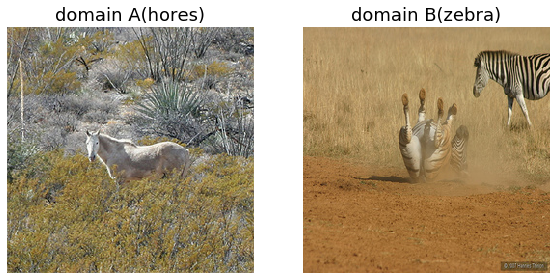

In [0]:
def compare_imshow(first_batch, second_batch, first_title="first_batch", second_title ="second_batch", nrow=1, third_batch =None, third_title="third_batch"):
  # Plot the first batch
  plt.figure(figsize=(15,15))
  plt.subplot(1,3,1)
  plt.axis("off")
  plt.title(first_title)
  plt.imshow(np.transpose(vutils.make_grid(first_batch, nrow=nrow,padding=2, normalize=True).cpu(),(1,2,0)))
  # Plot the fake images from the last epoch
  plt.subplot(1,3,2)
  plt.axis("off")
  plt.title(second_title)
  plt.imshow(np.transpose(vutils.make_grid(second_batch, nrow=nrow,padding=2, normalize=True).cpu(),(1,2,0)))

  if third_batch is not None:
    plt.subplot(1,3,3)
    plt.axis("off")
    plt.title(third_title)
    plt.imshow(np.transpose(vutils.make_grid(third_batch, nrow=nrow,padding=2, normalize=True).cpu(),(1,2,0)))


domain_a_batch, _ = next(train_a_iter)
domain_b_batch, _ = next(train_b_iter)
compare_imshow(domain_a_batch,domain_b_batch,"domain A(horse)","domain B(zebra)")
print("domain A Batch size : %s "%str(domain_a_batch.size()))
print("domain B Batch size : %s "%str(domain_b_batch.size()))

#ops

In [0]:
def conv_bn_layer(in_channels,out_channels,kernel_size,stride=1,padding=0,instance_norm=False):
  if instance_norm == True:
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
        nn.InstanceNorm2d(out_channels,momentum=0.1,eps=1e-5),
    )
  else:
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding),
        nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
    )
    
def tconv_bn_layer(in_channels,out_channels,kernel_size,stride=1,padding=0,output_padding=0,instance_norm=False):
  if instance_norm == True:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,output_padding=output_padding),
      nn.InstanceNorm2d(out_channels,momentum=0.1,eps=1e-5),
  )
  else:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,output_padding=output_padding),
      nn.BatchNorm2d(out_channels,momentum=0.1,eps=1e-5),
  )

def tconv_layer(in_channels,out_channels,kernel_size,stride=1,padding=0,output_padding=0,):
  return nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding,output_padding=output_padding)

def conv_layer(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Conv2d(in_channels,out_channels,kernel_size,stride=stride,padding=padding)

def fc_layer(in_features,out_features):
  return nn.Linear(in_features,out_features)

def fc_bn_layer(in_features,out_features,instance_norm=False):
  if instance_norm == True:
    return nn.Sequential(
      nn.Linear(in_features,out_features),
      nn.InstanceNorm2d(out_features)
  )
  else:
    return nn.Sequential(
      nn.Linear(in_features,out_features),
      nn.BatchNorm2d(out_features)
  )
    

# Models

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class ResnetBlock(nn.Module):
    def __init__(self, dim, instance_norm, use_dropout):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, instance_norm, use_dropout)

    def build_conv_block(self, dim, instance_norm, use_dropout):
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1)] # (n)x(n) -> (n+2)x(n+2)
        conv_block += [conv_bn_layer(dim, dim, 3,1,0,instance_norm=instance_norm), nn.ReLU(True)] # (n+2)x(n+2) -> (n)x(n)
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]
        conv_block += [nn.ReflectionPad2d(1)] # (n)x(n) -> (n+2)x(n+2)
        conv_block += [conv_bn_layer(dim,dim,3,1,0,instance_norm=instance_norm)] # (n+2)x(n+2) -> (n)x(n)
        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)  # skip connections
        return out

In [0]:
# Resblock based Generator

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, instance_norm=False, use_dropout=False, n_blocks=9):
        super(Generator, self).__init__()
        
        model = [nn.ReflectionPad2d(3),
                 conv_bn_layer(c_dim,ngf,7,1,0,instance_norm=instance_norm),
                 nn.ReLU(True)]
        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [conv_bn_layer(ngf * mult, ngf * mult * 2, 3,2,1,instance_norm=instance_norm),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks
            model += [ResnetBlock(ngf * mult, instance_norm=instance_norm, use_dropout=use_dropout)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [tconv_bn_layer(ngf * mult, int(ngf * mult / 2),
                                         3,2,1, output_padding=1,instance_norm=instance_norm),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, 7,1,0)]
        model += [nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)


In [0]:
# pixel gan (70x70 receptive field)

"""
reference : https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/39
reference : https://github.com/phillipi/pix2pix/blob/master/models.lua

In fact, a "PatchGAN" is just a convnet! Or you could say all convnets are patchnets: the power of convnets is that they process each image patch identically and independently, which makes things very cheap (# params, time, memory), and, amazingly, turns out to work.

The difference between a PatchGAN and regular GAN discriminator is that rather the regular GAN maps from a 256x256 image to a single scalar output, which signifies "real" or "fake", whereas the PatchGAN maps from 256x256 to an NxN array of outputs X, where each X_ij signifies whether the patch ij in the image is real or fake. Which is patch ij in the input? Well, output X_ij is just a neuron in a convnet, and we can trace back its receptive field to see which input pixels it is sensitive to. In the CycleGAN architecture, the receptive fields of the discriminator turn out to be 70x70 patches in the input image!

This is all mathematically equivalent to if we had manually chopped up the image into 70x70 overlapping patches, run a regular discriminator over each patch, and averaged the results.

Maybe it would have been better if we called it a "Fully Convolutional GAN" like in FCNs... it's the same idea :)
"""

class Discriminator(nn.Module):
  def __init__(self,instance_norm=False):#input : 256x256
    super(Discriminator,self).__init__()
    self.conv1 = conv_layer(c_dim,df_dim,4,2,1) # 128x128
    self.conv2 = conv_bn_layer(df_dim,df_dim*2,4,2,1,instance_norm=instance_norm)# 64x64
    self.conv3 = conv_bn_layer(df_dim*2,df_dim*4,4,2,1,instance_norm=instance_norm)# 32 x 32
    self.conv4 = conv_bn_layer(df_dim*4,df_dim*8,4,1,1,instance_norm=instance_norm)# 31 x 31
    self.conv5 = conv_layer(df_dim*8,1,4,1,1)# 30 x 30

    self.sigmoid = nn.Sigmoid()


  def forward(self, x):
    x=F.leaky_relu(self.conv1(x),0.2)
    x=F.leaky_relu(self.conv2(x),0.2)
    x=F.leaky_relu(self.conv3(x),0.2)
    x=F.leaky_relu(self.conv4(x),0.2)
    x=self.conv5(x)

    return self.sigmoid(x)


In [0]:
def weights_init(m):
  classname =m.__class__.__name__
  if classname.find('Conv')!=-1 or classname.find('Linear')!=-1: # for Conv,Linear
    nn.init.normal_(m.weight.data,0.0,0.02)
    nn.init.constant_(m.bias.data,0)
  elif classname.find('BatchNorm')!=-1:# Reference : https://discuss.pytorch.org/t/weight-initialization-for-batchnorm-in-dcgan-tutorial/32351
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)

# Train configs

In [0]:
import torch.optim as optim
import torch.nn as nn

G_A = Generator(c_dim,c_dim,instance_norm=instance_norm).to(device)
G_B = Generator(c_dim,c_d im,instance_norm=instance_norm).to(device)
D_A = Discriminator(instance_norm).to(device)
D_B = Discriminator(instance_norm).to(device)

mse_criterion = nn.MSELoss() # to calculate GAN loss by lsgan objective
L1_criterion = nn.L1Loss() # to calculate cycle-consistency

G_A_optimizer = optim.Adam(G_A.parameters(), lr=2e-4,betas=(0.5,0.999))
G_B_optimizer = optim.Adam(G_B.parameters(), lr=2e-4,betas=(0.5,0.999))
D_A_optimizer = optim.Adam(D_A.parameters(), lr=2e-4,betas=(0.5,0.999))
D_B_optimizer = optim.Adam(D_B.parameters(), lr=2e-4,betas=(0.5,0.999))

# fixed_a_condition, _ = next(iter(test_a_loader))
fixed_a_condition = None
fixed_b_condition = None

for i, (t, _) in enumerate(test_a_loader):
  if i ==0:
    fixed_a_condition = t
  elif i ==4:
    break
  else:
    fixed_a_condition=torch.cat((fixed_a_condition,t),0)

for i, (t, _) in enumerate(test_b_loader):
  if i ==0:
    fixed_b_condition = t
  elif i ==4:
    break
  else:
    fixed_b_condition=torch.cat((fixed_b_condition,t),0)


fixed_a_condition = fixed_a_condition.to(device)
fixed_b_condition = fixed_b_condition.to(device)

print(D_A.apply(weights_init))
print(D_B.apply(weights_init))
print(G_A.apply(weights_init))
print(G_B.apply(weights_init))

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (sigmoid): Sigmoid()
)
Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm

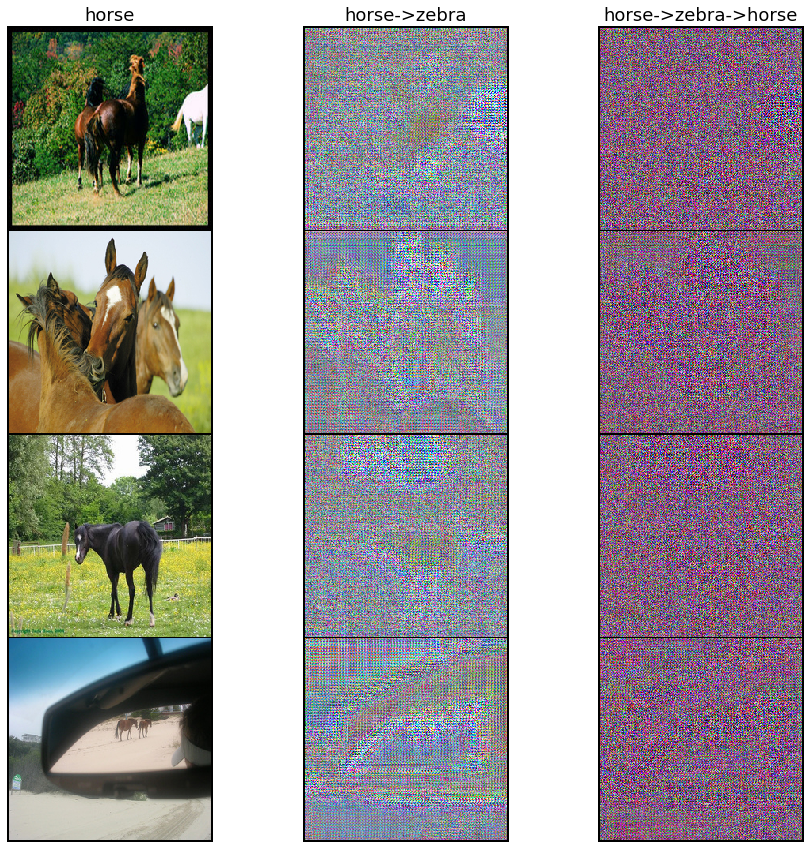

In [0]:
with torch.no_grad():
  fake_batch=G_A(fixed_a_condition)
  fake_recon_batch=G_B(fake_batch)
compare_imshow(fixed_a_condition,fake_batch,first_title="horse",second_title="horse->zebra",third_batch =fake_recon_batch,third_title="horse->zebra->horse")

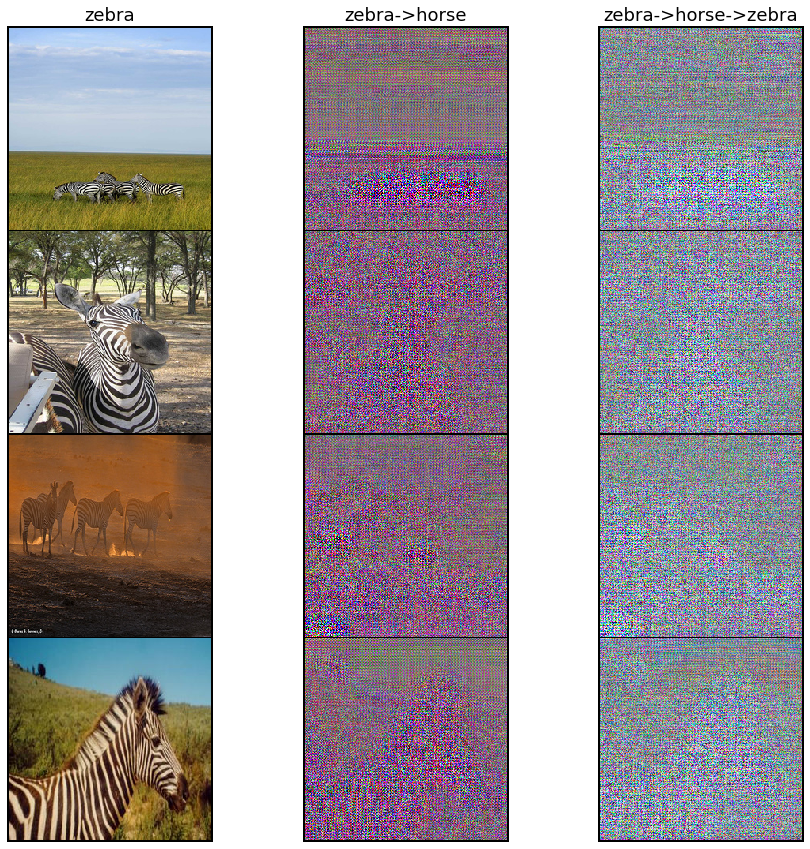

In [0]:
with torch.no_grad():
  fake_batch=G_B(fixed_b_condition)
  fake_recon_batch = G_A(fake_batch)
compare_imshow(fixed_b_condition,fake_batch,first_title="zebra",second_title="zebra->horse",third_batch = fake_recon_batch, third_title="zebra->horse->zebra")

In [0]:
img_a_list = []
img_b_list = []
D_A_GAN_losses = []
D_B_GAN_losses = []
G_A_GAN_losses = []
G_B_GAN_losses = []

cycle_A_B_A_losses = []
cycle_B_A_B_losses = []

iter_per_plot = 250
plot_per_eps=(int(len(train_a_loader)/iter_per_plot))
transform_PIL=transforms.ToPILImage()

train_data_length = len(train_a_loader) if len(train_a_loader) < len(train_b_loader) else len(train_b_loader)

def log_list_save(l,file_name):
  with open(os.path.join(log_PATH ,file_name+".logs"), "wb") as fp:
    pickle.dump(l, fp)

def log_list_load(file_name):
  with open(os.path.join(log_PATH ,file_name+".logs"), "rb") as fp:
    return pickle.load(fp)

#Train

In [0]:
for ep in range(epochs):
  for ((i, (a_data, _)), (b_data, _)) in zip(enumerate(train_a_loader), train_b_loader):
    b_size= a_data.shape[0]
    
    a_data=a_data.to(device)
    b_data=b_data.to(device)

    real_masks = torch.ones(b_size,1,30,30).to(device)
    fake_masks = torch.zeros(b_size,1,30,30).to(device)

    #Train D
    ## D_A
    D_A.zero_grad()
    real_patch=D_A(a_data)
    real_gan_loss=mse_criterion(real_patch,real_masks)

    fake_A = G_B(b_data)
    fake_patch = D_A(fake_A.detach())
    fake_gan_loss=mse_criterion(fake_patch,fake_masks)    

    D_A_GAN_loss = real_gan_loss + fake_gan_loss
    D_A_GAN_loss.backward()
    D_A_optimizer.step()

    ## B->A
    D_B.zero_grad()
    real_patch=D_B(b_data)
    real_gan_loss=mse_criterion(real_patch,real_masks)

    fake_B = G_A(a_data)
    fake_patch = D_B(fake_B.detach())
    fake_gan_loss=mse_criterion(fake_patch,fake_masks)

    D_B_GAN_loss = real_gan_loss + fake_gan_loss
    D_B_GAN_loss.backward()
    D_B_optimizer.step()


    ##Train G
    G_A.zero_grad()
    fake_patch = D_B(fake_B)
    G_A_GAN_loss=mse_criterion(fake_patch,real_masks)

    G_B.zero_grad()
    fake_patch = D_A(fake_A)
    G_B_GAN_loss=mse_criterion(fake_patch,real_masks)
    
    #Cycle consistency
    ## A->B->A
    fake_B_A=G_B(fake_B)
    cycle_A_loss=L1_criterion(fake_B_A,a_data)
    
    ## B->A->B
    fake_A_B=G_A(fake_A)
    cycle_B_loss=L1_criterion(fake_A_B,b_data)

    G_loss=G_A_GAN_loss+G_B_GAN_loss+ lambda_a*cycle_A_loss + lambda_b*cycle_B_loss
    G_loss.backward()
    G_A_optimizer.step()
    G_B_optimizer.step()

    if (i+1)%iter_per_plot == 0 :
      print('Epoch [{}/{}], Step [{}/{}], D_A_loss: {:.4f}, D_B_loss: {:.4f},G_A_loss: {:.4f}, G_B_loss:{:.4f},A_cycle_loss:{:.4f},B_cycle_loss:{:.4f}' 
            .format(ep, epochs, i+1, len(train_a_loader), D_A_GAN_loss.item(), D_B_GAN_loss.item(),G_A_GAN_loss.item(), G_B_GAN_loss.item(),cycle_A_loss.item(),cycle_B_loss.item()))
      D_A_GAN_losses.append(D_A_GAN_loss.item())
      D_B_GAN_losses.append(D_B_GAN_loss.item())
      G_A_GAN_losses.append(G_A_GAN_loss.item())
      G_B_GAN_losses.append(G_B_GAN_loss.item())

      cycle_A_B_A_losses.append(cycle_A_loss.item())
      cycle_B_A_B_losses.append(cycle_B_loss.item())

      with torch.no_grad():
        G_A.eval()
        G_B.eval()
        fake_B = G_A(fixed_a_condition).detach()
        fake_B_A = G_B(fake_B).detach()
        fake_A = G_B(fixed_b_condition).detach()
        fake_A_B = G_A(fake_A).detach()
        G_A.train()
        G_B.train()
      figs=plt.figure(figsize=(10,10))
      plt.subplot(1,3,1)
      plt.axis("off")
      plt.title("horse")
      plt.imshow(np.transpose(vutils.make_grid(fixed_a_condition, nrow=1,padding=5, normalize=True).cpu(),(1,2,0)))
      plt.subplot(1,3,2)
      plt.axis("off")
      plt.title("horse -> zebra")
      plt.imshow(np.transpose(vutils.make_grid(fake_B, nrow=1,padding=5, normalize=True).cpu(),(1,2,0)))
      plt.subplot(1,3,3)
      plt.axis("off")
      plt.title("horse -> zebra -> horse")
      plt.imshow(np.transpose(vutils.make_grid(fake_B_A, nrow=1,padding=5, normalize=True).cpu(),(1,2,0)))
      plt.savefig(os.path.join(log_PATH,modelName+"A-"+str(ep) +".png"))
      plt.close()
      img_a_list.append(figs)

      figs=plt.figure(figsize=(10,10))
      plt.subplot(1,3,1)
      plt.axis("off")
      plt.title("zebra")
      plt.imshow(np.transpose(vutils.make_grid(fixed_b_condition, nrow=1,padding=5, normalize=True).cpu(),(1,2,0)))
      plt.subplot(1,3,2)
      plt.axis("off")
      plt.title("zebra -> horse")
      plt.imshow(np.transpose(vutils.make_grid(fake_A, nrow=1,padding=5, normalize=True).cpu(),(1,2,0)))
      plt.subplot(1,3,3)
      plt.axis("off")
      plt.title("zebra -> horse -> zebra")
      plt.imshow(np.transpose(vutils.make_grid(fake_A_B, nrow=1,padding=5, normalize=True).cpu(),(1,2,0)))
      plt.savefig(os.path.join(log_PATH,modelName+"B-"+str(ep) +".png"))
      plt.close()
      img_b_list.append(figs)

      log_list_save(D_A_GAN_losses,"D_A_GAN_losses")
      log_list_save(D_B_GAN_losses,"D_B_GAN_losses")
      log_list_save(G_A_GAN_losses,"G_A_GAN_losses")
      log_list_save(G_B_GAN_losses,"G_B_GAN_losses")
      log_list_save(cycle_A_B_A_losses,"cycle_A_B_A_losses")
      log_list_save(cycle_B_A_B_losses,"cycle_B_A_B_losses") 

      torch.save(D_A.state_dict(),os.path.join(log_PATH,"D_A_"+modelName+".pth"))
      torch.save(D_B.state_dict(),os.path.join(log_PATH,"D_B_"+modelName+".pth"))
      torch.save(G_A.state_dict(),os.path.join(log_PATH,"G_A_"+modelName+".pth"))
      torch.save(G_B.state_dict(),os.path.join(log_PATH,"G_B_"+modelName+".pth"))

Epoch [67/100], Step [250/1067], D_A_loss: 0.1388, D_B_loss: 0.0363,G_A_loss: 0.9245, G_B_loss:0.7332,A_cycle_loss:0.1267,B_cycle_loss:0.1332
Epoch [67/100], Step [500/1067], D_A_loss: 0.1410, D_B_loss: 0.0225,G_A_loss: 0.8630, G_B_loss:0.8102,A_cycle_loss:0.0788,B_cycle_loss:0.0880
Epoch [67/100], Step [750/1067], D_A_loss: 0.2613, D_B_loss: 0.1365,G_A_loss: 0.9641, G_B_loss:0.6145,A_cycle_loss:0.1106,B_cycle_loss:0.0887
Epoch [67/100], Step [1000/1067], D_A_loss: 0.3307, D_B_loss: 0.1205,G_A_loss: 0.9131, G_B_loss:0.8580,A_cycle_loss:0.1682,B_cycle_loss:0.1563
Epoch [68/100], Step [250/1067], D_A_loss: 0.3294, D_B_loss: 0.2410,G_A_loss: 0.8939, G_B_loss:0.7174,A_cycle_loss:0.0941,B_cycle_loss:0.1423
Epoch [68/100], Step [500/1067], D_A_loss: 0.1654, D_B_loss: 0.0129,G_A_loss: 0.9373, G_B_loss:0.7367,A_cycle_loss:0.0958,B_cycle_loss:0.1223
Epoch [68/100], Step [750/1067], D_A_loss: 0.0264, D_B_loss: 0.0024,G_A_loss: 0.9737, G_B_loss:0.9896,A_cycle_loss:0.1070,B_cycle_loss:0.0888
Epoch

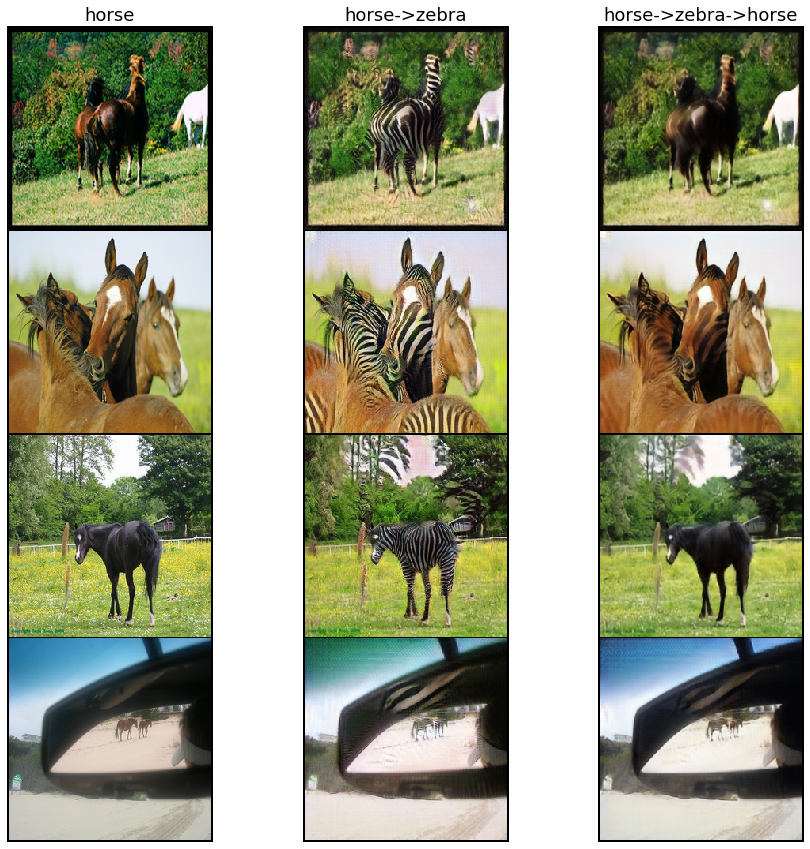

In [0]:
with torch.no_grad():
  fake_batch=G_A(fixed_a_condition)
  fake_recon_batch=G_B(fake_batch)
compare_imshow(fixed_a_condition,fake_batch,first_title="horse",second_title="horse->zebra",third_batch =fake_recon_batch,third_title="horse->zebra->horse")

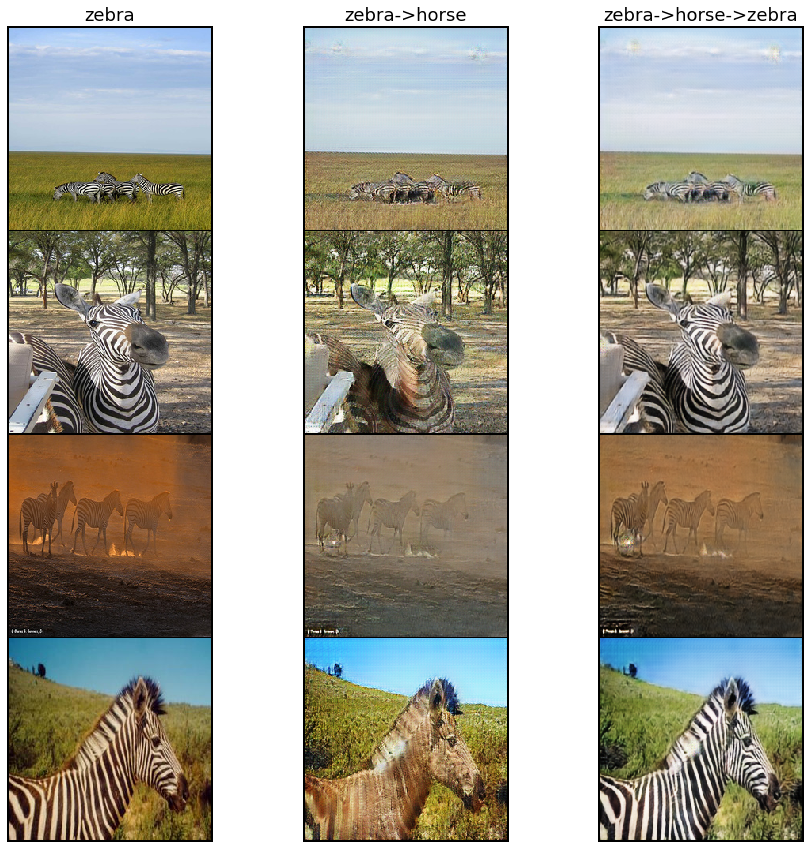

In [0]:
with torch.no_grad():
  fake_batch=G_B(fixed_b_condition)
  fake_recon_batch = G_A(fake_batch)
compare_imshow(fixed_b_condition,fake_batch,first_title="zebra",second_title="zebra->horse",third_batch = fake_recon_batch, third_title="zebra->horse->zebra")

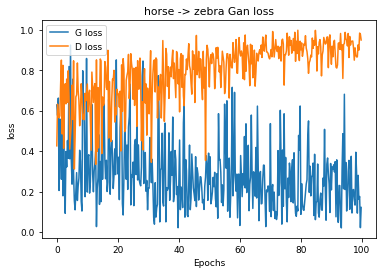

In [0]:
plt.title("horse -> zebra Gan loss")

epsilon = 1/plot_per_eps
X = np.array(range(plot_per_eps*epochs))/plot_per_eps
plt.rc('font',size =9)
plt.plot(X,D_A_GAN_losses,label="G loss")
plt.plot(X,G_A_GAN_losses,label="D loss")
plt.legend(loc=2)
plt.xticks(np.arange(0,epochs+1,20)) 
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.savefig(modelName+"h2z_loss_figure.png")

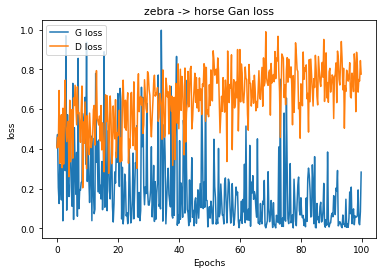

In [0]:
plt.title("zebra -> horse Gan loss")

epsilon = 1/plot_per_eps
X = np.array(range(plot_per_eps*epochs))/plot_per_eps
plt.rc('font',size =9)
plt.plot(X,D_B_GAN_losses,label="G loss")
plt.plot(X,G_B_GAN_losses,label="D loss")
plt.legend(loc=2)
plt.xticks(np.arange(0,epochs+1,20)) 
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.savefig(modelName+"z2h_loss_figure.png")

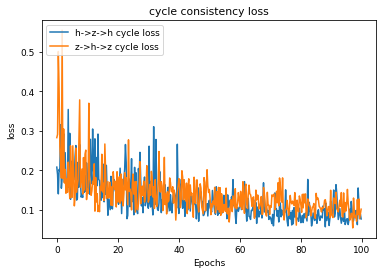

In [0]:
plt.title("cycle consistency loss")

epsilon = 1/plot_per_eps
X = np.array(range(plot_per_eps*epochs))/plot_per_eps
plt.rc('font',size =9)
plt.plot(X,cycle_A_B_A_losses,label="h->z->h cycle loss")
plt.plot(X,cycle_B_A_B_losses,label="z->h->z cycle loss")
plt.legend(loc=2)
plt.xticks(np.arange(0,epochs+1,20)) 
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.savefig(modelName+"cycle_loss_figure.png")

# Model save

In [0]:
torch.save(D_A.state_dict(),os.path.join(log_PATH,"D_A_"+modelName+".pth"))
torch.save(D_B.state_dict(),os.path.join(log_PATH,"D_B_"+modelName+".pth"))
torch.save(G_A.state_dict(),os.path.join(log_PATH,"G_A_"+modelName+".pth"))
torch.save(G_B.state_dict(),os.path.join(log_PATH,"G_B_"+modelName+".pth"))

In [0]:
D_A.load_state_dict(torch.load(os.path.join(log_PATH,"D_A_"+modelName+".pth")))
D_B.load_state_dict(torch.load(os.path.join(log_PATH,"D_B_"+modelName+".pth")))
G_A.load_state_dict(torch.load(os.path.join(log_PATH,"G_A_"+modelName+".pth")))
G_B.load_state_dict(torch.load(os.path.join(log_PATH,"G_B_"+modelName+".pth")))

<All keys matched successfully>